## Unsupervised Sentiment Analysis using VADER

In [15]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import movie_reviews
import random

# Download required NLTK data
nltk.download('movie_reviews')
nltk.download('vader_lexicon')

print("VADER Sentiment Analysis - Unsupervised Approach")
print("=" * 50)

VADER Sentiment Analysis - Unsupervised Approach


[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/chanhengmenh/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/chanhengmenh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
ramdom_seed = 94


print("\nLoading NLTK Movie Reviews Dataset...")

# Load movie reviews dataset (same as supervised approach for fair comparison)
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Shuffle with same seed for consistency
random.seed(ramdom_seed)
random.shuffle(documents)

# Convert to text format
texts = [' '.join(words) for words, category in documents]
labels = [category for words, category in documents]

print(f"Total reviews: {len(documents)}")
print(f"Positive reviews: {len(movie_reviews.fileids('pos'))}")
print(f"Negative reviews: {len(movie_reviews.fileids('neg'))}")


Loading NLTK Movie Reviews Dataset...
Total reviews: 2000
Positive reviews: 1000
Negative reviews: 1000


In [17]:
print("\nInitializing VADER Sentiment Analyzer...")

# VADER is a lexicon and rule-based sentiment analysis tool
# It uses a pre-built dictionary of sentiment-bearing words
# and applies rules for handling negations, intensifiers, etc.
analyzer = SentimentIntensityAnalyzer()

print("VADER analyzer initialized successfully!")
print("\nVADER returns 4 scores:")
print("- Negative: proportion of text that falls in negative category")
print("- Neutral: proportion of text that falls in neutral category")
print("- Positive: proportion of text that falls in positive category")
print("- Compound: normalized, weighted composite score (-1 to +1)")


Initializing VADER Sentiment Analyzer...
VADER analyzer initialized successfully!

VADER returns 4 scores:
- Negative: proportion of text that falls in negative category
- Neutral: proportion of text that falls in neutral category
- Positive: proportion of text that falls in positive category
- Compound: normalized, weighted composite score (-1 to +1)


In [18]:
print("\nAnalyzing sentiment for all reviews...")

# Store results
vader_results = []
predictions = []
number_of_reviews = 500

# Put texts into a DataFrame for vectorized operations
df = pd.DataFrame({"review": texts})

# Apply VADER sentiment analysis to each review
df["vader_scores"] = df["review"].apply(lambda x: analyzer.polarity_scores(x))

# Extract compound score
df["compound"] = df["vader_scores"].apply(lambda score: score["compound"])

# Convert compound score to binary classification
df["prediction"] = df["compound"].apply(lambda c: "pos" if c >= 0 else "neg")

print("Sentiment analysis completed!")


Analyzing sentiment for all reviews...
Sentiment analysis completed!


In [ ]:
# Start with your DataFrame that already has review, vader_scores, compound, prediction
df["positive_score"] = df["vader_scores"].apply(lambda score: score["pos"])
df["negative_score"] = df["vader_scores"].apply(lambda score: score["neg"])
df["neutral_score"]  = df["vader_scores"].apply(lambda score: score["neu"])

# Add actual labels if you have them
df["actual_label"] = labels   # must be same length as texts
df["predicted_label"] = df["prediction"]

# Rename for clarity (optional)
df_results = df.rename(columns={"review": "text"})

print(f"\nResults DataFrame shape: {df_results.shape}")
print("\nFirst 5 results:")
print(df_results[["actual_label", "predicted_label", "compound"]].head())


ValueError: All arrays must be of the same length

In [ ]:
print("\nEvaluating VADER Performance:")
print("=" * 40)

# Calculate accuracy
accuracy = accuracy_score(labels, predictions)
print(f"Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(labels, predictions, target_names=['neg', 'pos']))

# Confusion Matrix
cm = confusion_matrix(labels, predictions, labels=['neg', 'pos'])
print(f"\nConfusion Matrix:")
print(cm)


Evaluating VADER Performance:
Overall Accuracy: 0.628 (62.8%)

Detailed Classification Report:
              precision    recall  f1-score   support

         neg       0.72      0.42      0.53      1000
         pos       0.59      0.83      0.69      1000

    accuracy                           0.63      2000
   macro avg       0.65      0.63      0.61      2000
weighted avg       0.65      0.63      0.61      2000


Confusion Matrix:
[[423 577]
 [167 833]]



Creating visualizations...


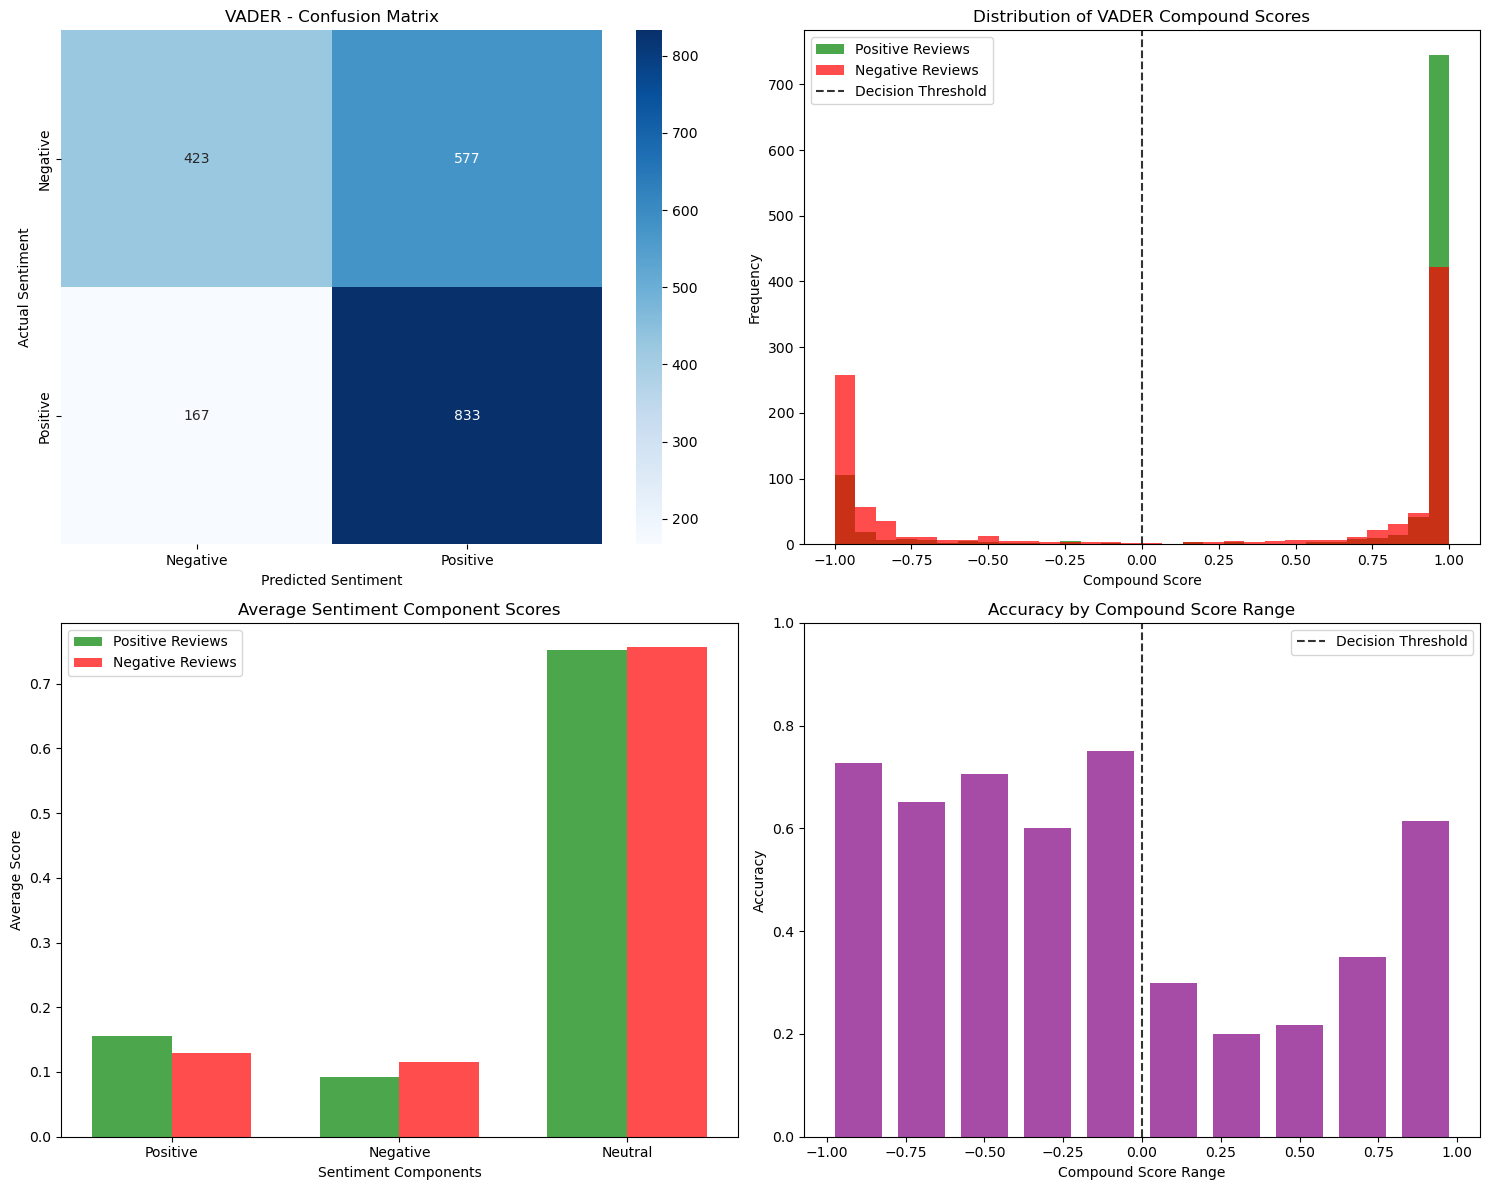

In [ ]:
print("\nCreating visualizations...")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], ax=axes[0, 0])
axes[0, 0].set_title('VADER - Confusion Matrix')
axes[0, 0].set_ylabel('Actual Sentiment')
axes[0, 0].set_xlabel('Predicted Sentiment')

# 2. Distribution of Compound Scores
axes[0, 1].hist(df_results[df_results['actual_label'] == 'pos']['compound_score'],
                alpha=0.7, label='Positive Reviews', bins=30, color='green')
axes[0, 1].hist(df_results[df_results['actual_label'] == 'neg']['compound_score'],
                alpha=0.7, label='Negative Reviews', bins=30, color='red')
axes[0, 1].axvline(x=0, color='black', linestyle='--',
                   alpha=0.8, label='Decision Threshold')
axes[0, 1].set_title('Distribution of VADER Compound Scores')
axes[0, 1].set_xlabel('Compound Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Sentiment Score Components by Actual Label
sentiment_components = ['positive_score', 'negative_score', 'neutral_score']
pos_means = [df_results[df_results['actual_label'] == 'pos'][comp].mean()
             for comp in sentiment_components]
neg_means = [df_results[df_results['actual_label'] == 'neg'][comp].mean()
             for comp in sentiment_components]

x = np.arange(len(sentiment_components))
width = 0.35

axes[1, 0].bar(x - width/2, pos_means, width,
               label='Positive Reviews', color='green', alpha=0.7)
axes[1, 0].bar(x + width/2, neg_means, width,
               label='Negative Reviews', color='red', alpha=0.7)
axes[1, 0].set_title('Average Sentiment Component Scores')
axes[1, 0].set_xlabel('Sentiment Components')
axes[1, 0].set_ylabel('Average Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Positive', 'Negative', 'Neutral'])
axes[1, 0].legend()

# 4. Accuracy by Compound Score Range
# Bin compound scores and calculate accuracy for each bin
bins = np.linspace(-1, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_accuracies = []

for i in range(len(bins)-1):
    mask = (df_results['compound_score'] >= bins[i]) & (
        df_results['compound_score'] < bins[i+1])
    if mask.sum() > 0:  # Only if there are samples in this bin
        bin_acc = accuracy_score(df_results[mask]['actual_label'],
                                 df_results[mask]['predicted_label'])
        bin_accuracies.append(bin_acc)
    else:
        bin_accuracies.append(0)

axes[1, 1].bar(bin_centers, bin_accuracies,
               width=0.15, alpha=0.7, color='purple')
axes[1, 1].axvline(x=0, color='black', linestyle='--',
                   alpha=0.8, label='Decision Threshold')
axes[1, 1].set_title('Accuracy by Compound Score Range')
axes[1, 1].set_xlabel('Compound Score Range')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
print("\nAnalyzing Sample Predictions:")
print("=" * 50)

# Show some correct and incorrect predictions
correct_predictions = df_results[df_results['actual_label']
                                 == df_results['predicted_label']]
incorrect_predictions = df_results[df_results['actual_label']
                                   != df_results['predicted_label']]

print(
    f"Correct predictions: {len(correct_predictions)} ({len(correct_predictions)/len(df_results)*100:.1f}%)")
print(
    f"Incorrect predictions: {len(incorrect_predictions)} ({len(incorrect_predictions)/len(df_results)*100:.1f}%)")

# Show examples of correct predictions
print("\nExamples of CORRECT Predictions:")
print("-" * 40)
sample_correct = correct_predictions.sample(n=3, random_state=42)
for idx, row in sample_correct.iterrows():
    print(f"Review: {row['text'][:200]}...")
    print(
        f"Actual: {row['actual_label'].upper()}, Predicted: {row['predicted_label'].upper()}")
    print(f"Compound Score: {row['compound_score']:.3f}")
    print(
        f"Scores - Pos: {row['positive_score']:.3f}, Neg: {row['negative_score']:.3f}, Neu: {row['neutral_score']:.3f}")
    print()

# Show examples of incorrect predictions
print("Examples of INCORRECT Predictions:")
print("-" * 40)
sample_incorrect = incorrect_predictions.sample(n=3, random_state=42)
for idx, row in sample_incorrect.iterrows():
    print(f"Review: {row['text'][:200]}...")
    print(
        f"Actual: {row['actual_label'].upper()}, Predicted: {row['predicted_label'].upper()}")
    print(f"Compound Score: {row['compound_score']:.3f}")
    print(
        f"Scores - Pos: {row['positive_score']:.3f}, Neg: {row['negative_score']:.3f}, Neu: {row['neutral_score']:.3f}")
    print()


Analyzing Sample Predictions:
Correct predictions: 1256 (62.8%)
Incorrect predictions: 744 (37.2%)

Examples of CORRECT Predictions:
----------------------------------------
Review: let ' s face it : the $ 100 million - plus smash that was " goldeneye " was not a good film by any means , and as a bond movie was only marginally better than , say , " a view to a kill " or either of...
Actual: POS, Predicted: POS
Compound Score: 0.996
Scores - Pos: 0.187, Neg: 0.088, Neu: 0.725

Review: there ' s something about ben stiller that makes him a popular choice among casting directors these days . stiller currently has three projects in circulation , and what other actor can lay claim to t...
Actual: POS, Predicted: POS
Compound Score: 0.898
Scores - Pos: 0.083, Neg: 0.053, Neu: 0.864

Review: i ' ll be the first to admit i didn ' t expect much from the emperor ' s new groove : more celine dion - esque song - and - dance numbers , cuddly characters that become cross - promotion devices in m...

In [ ]:
custom_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.",
    "I was completely bored by this film. The story dragged on forever and the characters were uninteresting.",
    "An incredible masterpiece! The cinematography was breathtaking and the performances were outstanding.",
    "What a waste of time. Poor acting, terrible script, and boring scenes. I couldn't wait for it to end.",
    "The movie was okay, nothing special but not terrible either. Some good moments but overall average."
]

print("Testing VADER with Custom Movie Reviews:")
print("=" * 60)

for i, review in enumerate(custom_reviews):
    scores = analyzer.polarity_scores(review)
    predicted_sentiment = 'POSITIVE' if scores['compound'] >= 0 else 'NEGATIVE'

    print(f"\nReview {i+1}:")
    print(f"Text: {review}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Compound Score: {scores['compound']:.3f}")
    print(
        f"Detailed Scores - Pos: {scores['pos']:.3f}, Neg: {scores['neg']:.3f}, Neu: {scores['neu']:.3f}")
    print("-" * 60)

Testing VADER with Custom Movie Reviews:

Review 1:
Text: This movie was absolutely fantastic! The acting was superb and the plot was engaging throughout.
Predicted Sentiment: POSITIVE
Compound Score: 0.893
Detailed Scores - Pos: 0.471, Neg: 0.000, Neu: 0.529
------------------------------------------------------------

Review 2:
Text: I was completely bored by this film. The story dragged on forever and the characters were uninteresting.
Predicted Sentiment: NEGATIVE
Compound Score: -0.380
Detailed Scores - Pos: 0.000, Neg: 0.204, Neu: 0.796
------------------------------------------------------------

Review 3:
Text: An incredible masterpiece! The cinematography was breathtaking and the performances were outstanding.
Predicted Sentiment: POSITIVE
Compound Score: 0.908
Detailed Scores - Pos: 0.559, Neg: 0.000, Neu: 0.441
------------------------------------------------------------

Review 4:
Text: What a waste of time. Poor acting, terrible script, and boring scenes. I couldn't wait f

In [ ]:
print("\nPerformance Analysis by Confidence Levels:")
print("=" * 50)

# Define confidence ranges based on absolute compound score
high_confidence = df_results[abs(df_results['compound_score']) >= 0.5]
medium_confidence = df_results[(abs(df_results['compound_score']) >= 0.1) &
                               (abs(df_results['compound_score']) < 0.5)]
low_confidence = df_results[abs(df_results['compound_score']) < 0.1]

for name, data in [("High Confidence (|compound| >= 0.5)", high_confidence),
                   ("Medium Confidence (0.1 <= |compound| < 0.5)", medium_confidence),
                   ("Low Confidence (|compound| < 0.1)", low_confidence)]:
    if len(data) > 0:
        acc = accuracy_score(data['actual_label'], data['predicted_label'])
        print(f"{name}: {len(data)} reviews, Accuracy: {acc:.3f} ({acc*100:.1f}%)")
    else:
        print(f"{name}: No reviews in this range")


Performance Analysis by Confidence Levels:
High Confidence (|compound| >= 0.5): 1922 reviews, Accuracy: 0.633 (63.3%)
Medium Confidence (0.1 <= |compound| < 0.5): 70 reviews, Accuracy: 0.514 (51.4%)
Low Confidence (|compound| < 0.1): 8 reviews, Accuracy: 0.375 (37.5%)


In [ ]:
print("\n" + "="*70)
print("COMPARISON: UNSUPERVISED (VADER) vs SUPERVISED (Logistic Regression)")
print("="*70)

print(f"""
VADER (Unsupervised) Results:
- Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)
- No training required
- Works out-of-the-box
- Rule-based approach with pre-built lexicon
- Handles negations, intensifiers, and punctuation
- Fast inference (no vectorization needed)
- Interpretable scores (compound, pos, neg, neu)

Expected Supervised (Logistic Regression) Results (from provided code):
- Test Accuracy: ~0.850 (85.0%)
- Requires training on labeled data  
- Uses TF-IDF vectorization
- Learns domain-specific patterns
- Can capture context better
- Slower inference (requires preprocessing + vectorization)

KEY OBSERVATIONS:
1. Supervised approach typically achieves higher accuracy (~85% vs ~{accuracy*100:.1f}%)
2. VADER requires no training and works immediately
3. VADER handles linguistic nuances (negations, intensifiers) well
4. Supervised model learns movie-specific vocabulary and patterns
5. VADER provides interpretable confidence scores
6. Trade-off between convenience (VADER) and performance (supervised)

WHEN TO USE EACH:
- Use VADER for: Quick deployment, no labeled data, general domains
- Use Supervised for: Higher accuracy needs, domain-specific tasks, when labeled data is available
""")

print("\nAnalysis completed!")
print(f"Total reviews processed: {len(df_results)}")
print(f"VADER accuracy: {accuracy:.3f}")
print("Review the visualizations and analysis above for detailed insights.")


COMPARISON: UNSUPERVISED (VADER) vs SUPERVISED (Logistic Regression)

VADER (Unsupervised) Results:
- Overall Accuracy: 0.628 (62.8%)
- No training required
- Works out-of-the-box
- Rule-based approach with pre-built lexicon
- Handles negations, intensifiers, and punctuation
- Fast inference (no vectorization needed)
- Interpretable scores (compound, pos, neg, neu)

Expected Supervised (Logistic Regression) Results (from provided code):
- Test Accuracy: ~0.850 (85.0%)
- Requires training on labeled data  
- Uses TF-IDF vectorization
- Learns domain-specific patterns
- Can capture context better
- Slower inference (requires preprocessing + vectorization)

KEY OBSERVATIONS:
1. Supervised approach typically achieves higher accuracy (~85% vs ~62.8%)
2. VADER requires no training and works immediately
3. VADER handles linguistic nuances (negations, intensifiers) well
4. Supervised model learns movie-specific vocabulary and patterns
5. VADER provides interpretable confidence scores
6. Trade